<a href="https://colab.research.google.com/github/arvindcsekar/GW-PTA-PINN/blob/main/PTA_GW_PINN_db_dl_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

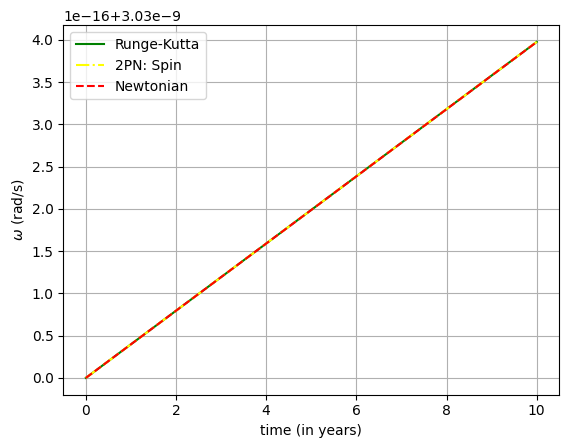

/tmp/ipython-input-1498071159.py:126: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


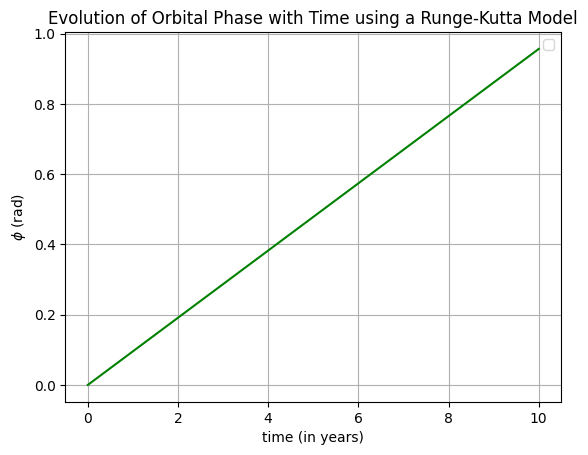

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as ac

G = 6.6743e-11 #big G constant
c = 3e8 #light
m = 1e9*1.989e30
m_chirp = (m**2)**(3/5) / ((2 * m)**(1/5))  # chirp mass
m_c = m_chirp
m_total = 2*m #total mass
nu = 1 #stated
eta = 0.25 #assuming both SMBHs of identical mass (1e9 solar masses)
chi = 0.5 #high spin SMBH assumed (equal, aligned spin)
Q_15 = 19/3*chi*eta -113/12*chi +4*np.pi #aligned spin case, 3rd term (delta) vanishes
omg_a = 3.03 * 1e-9 #from Kepler relation
omg_positive = 3.03 * 1e-9
yr = (365.25)*(24)*(60)*(60)
GMsun = ac.GM_sun.value
dsun = GMsun/(c**2)
tsun = GMsun/(c**3)
pc = ac.pc.value

def f(t, omg):
  tN_omg = G * m_chirp * omg / c**3 #post-Newtonian relation
  tm_omg = G * m_total * omg / c**3 #post-Newtonian relation
  return ((96/5) * omg**2 * tN_omg**(5/3) * (1 + (-743/336 - (11/4)*eta) * tm_omg**(2/3) * nu + Q_15 * tm_omg * nu**(3/2) + (34103/18144 + (13661/2016)*eta + (59/18)*eta**2) * tm_omg**(4/3) * nu**2))

def rk4(f, omg_0, t_f, t_0, h):
  n_steps = int((t_f - t_0)/h + 1) #define number of steps
  t = np.linspace(t_0, t_f, n_steps)
  omg = np.zeros(n_steps) #initialises empty omg array of the size of n_steps
  omg[0] = omg_0 #omg_0 at time t initialised

  for i in range(1, n_steps):
    k1 = h * f(t[i-1], omg[i-1])  #initial slope
    k2 = h * f(t[i-1] + h/2, omg[i-1] + k1/2)  #slope at midpoint using k1
    k3 = h * f(t[i-1] + h/2, omg[i-1] + k2/2)  #slope at midpoint using k2
    k4 = h * f(t[i-1] + h, omg[i-1] + k3)      #end slope using k3

    omg[i] = omg[i-1] + (k1 + 2*k2 + 2*k3 + k4)/6  #combine weighted slopes

  return t, omg

omg_0 = 3.03 * 1e-9
t_0 = 0
t_f = 10 * 365.25 * 24 * 3600
h = 1000

t, omg = rk4(f, omg_0, t_f, t_0, h)
t_years = t / yr

def get_omg(t,t_0,omg_a,m_c,eta,nu,chi_A,chi_S):
    m=1e9
    tN_ = m_c*omg_a*tsun
    tm_ = m*omg_a*tsun
    tmta_ = t-t_0
    delta=0
    tau = 1-256/5*omg_a*tN_**(5/3)*tmta_
    Q15=(-113/12*chi_A*delta+19/3*chi_S*eta-113/12*chi_S+4*np.pi)
    ww=(omg_a*(((371/128*eta**2+56975/16128*eta+1855099/903168)/tau**(7/8)+(-3058673/
    1354752-617/192*eta**2-5429/1344*eta)/tau**(11/8)+(-605/192*eta**2-40865/8064*eta-\
    2760245/1354752)/tau**(13/8)+(1331/384*eta**2+89903/16128*eta+6072539/2709504)/
    tau**(19/8))*tm_**(4/3)*nu**2+(3/5/tau**(11/8)*Q15-3/5/tau**(3/4)*Q15)*tm_*nu**(3/2)+
    ((11/8*eta+743/672)/tau**(5/8)+(-11/8*eta-743/672)/tau**(11/8))*tm_**(2/3)*nu+1/
    tau**(3/8)))
    return ww

t=np.linspace(0,10,100)*yr
omg_a= 3.03*1e-9
m_c=(1e9**2)**(3/5) / (2*1e9)**(1/5)
eta=1/4
nu=1
chi_A = 0
chi_S = 0.5
#chi_A ranges from (-0.5,0.5)
#chi_S ranges from (0,1)

omg_arr=get_omg(t,t_0,omg_a,m_c,eta,nu,chi_A,chi_S)
omg_arr_Q=get_omg(t,t_0,omg_a,m_c,eta,nu,chi_A,chi_S)

plt.plot(t/yr,omg_arr, linestyle="-", color="green")
plt.plot(t/yr,omg_arr_Q, linestyle="-.", color="yellow")
plt.plot(t_years, omg, linestyle="--", color="red")
plt.grid(True)
plt.legend(["Runge-Kutta", "2PN: Spin","Newtonian"])
plt.xlabel("time (in years)")
plt.ylabel(r"$\omega$ (rad/s)")
plt.show()

def rk4_phi(f, omg, phi_0, t_f, t_0, h):
  n_steps2 = int((t_f - t_0)/h + 1) #define number of steps
  t = np.linspace(t_0, t_f, n_steps2)
  phi = np.zeros(n_steps2) #initialises empty phi array of the size of n_steps2
  phi[0] = phi_0 #phi_0 at time t initialised

  t_omg = np.linspace(t_0, t_f, len(omg))

  def omega_of_tau(tau):
      return np.interp(tau, t_omg, omg)

  for w in range(0, n_steps2-1):
    h_local = t[w+1] - t[w]
    ti = t[w]

    k1 = omega_of_tau(ti)
    k2 = omega_of_tau(ti + 0.5*h_local)
    k3 = omega_of_tau(ti + 0.5*h_local)
    k4 = omega_of_tau(ti + h_local)

    phi[w+1] = phi[w] + (h_local/6.0)*(k1 + 2*k2 + 2*k3 + k4)

  return t, phi

omg_0 = 3.03 * 1e-9
t_0 = 0
t_f = 10 * 365.25 * 24 * 3600
h = 1000
phi_0 = 0

t, phi = rk4_phi(f, omg, phi_0, t_f, t_0, h)
t_years = t / yr

plt.plot(t_years, phi, color="green")
plt.grid(True)
plt.title("Evolution of Orbital Phase with Time using a Runge-Kutta Model")
plt.legend()
plt.xlabel("time (in years)")
plt.ylabel(r"$\phi$ (rad)")
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import astropy.constants as ac

torch.manual_seed(42)
np.random.seed(42)
G = torch.tensor(6.6743e-11, dtype=torch.float64) #big G constant
c = torch.tensor(3e8, dtype=torch.float64) #light
m = 1e9*1.989e30
m_c = m_chirp = torch.tensor((m**2)**(3/5) / ((2 * m )**(1/5)), dtype=torch.float64)  # chirp mass
m_total = torch.tensor(2*m, dtype=torch.float64) #total mass
nu = torch.tensor(1.0, dtype=torch.float64) #stated
eta = torch.tensor(0.25, dtype=torch.float64) #assuming both SMBHs of identical mass (1e9 solar masses)
chi = torch.tensor(0.5, dtype=torch.float64) #high spin SMBH assumed (equal, aligned spin)
Q_15 = 19/3*chi*eta -113/12*chi +4*np.pi #aligned spin case, 3rd term (delta) vanishes
omg_a = 3.03 * 1e-9 #from Kepler relation

class PINN(nn.Module):
  def __init__(self):
    super(PINN, self).__init__()
    self.net = nn.Sequential(
      nn.Linear(1, 64), #input 1 neuron (time), then 32 neurons in each hidden layer
      nn.Tanh(), #activation function
      nn.Linear(64, 64),
      nn.Tanh(),
      nn.Linear(64, 64),
      nn.Tanh(),
      nn.Linear(64, 64),
      nn.Tanh(),
      nn.Linear(64, 1, bias=True) #output layer, 1 neuron (solution, omega)
    )
    self.double() #Ensure the model parameters are of type float64


  def forward(self, t):
    return torch.exp(self.net(t))

num_points = 10000
t_end = 10 * 365.25 * 24 * 3600  #10 years in seconds
t_0 = 0
t = torch.rand(num_points, 1, dtype=torch.float64) #b/w t=0 and coalescence time, NORMALISED
input = t.requires_grad_() #tells PyTorch to track gradients wrt inputs
omg_enforced = torch.tensor(3.03* 1e-9, dtype=torch.float64) #kepler's relation for typical omg value at t=0, with M = 1e9 and R = 0.1pc

t_bc2 = torch.tensor([0.0], dtype=torch.float64).view(-1, 1)
loss_MSE = nn.MSELoss() #mean squared


#weights
w1 = 9e10
w2 = 7
w3 = 1e-14


def compute_residual_loss(model, t_batch):
    t_pred = t_batch.requires_grad_()
    omg_pred = model(t_pred)

    omg_positive = omg_pred
    t_physical = t_pred * t_end
    tN_omg = (G * m_chirp * omg_positive / (c**3)) ** (5/3)
    tm_omg_2by3 = (G * m_total * omg_positive / (c**3)) ** (2/3)
    tm_omg_1 = (G * m_total * omg_positive / (c**3))  #For Q_15 term
    tm_omg_4by3 = (G * m_total * omg_positive / (c**3)) ** (4/3)

    domg_dt = torch.autograd.grad(omg_positive, t_pred, grad_outputs=torch.ones_like(omg_positive),create_graph=True)[0]/t_end
    rhs = ((96/5) * omg_positive**2 * tN_omg * (
    1
    + (-743/336 - (11/4)*eta) * tm_omg_2by3 * nu
    + Q_15 * tm_omg_1 * nu**(3/2)
    + (34103/18144 + (13661/2016)*eta + (59/18)*eta**2) * tm_omg_4by3 * nu**2
))
    residual = domg_dt - rhs #LHS - RHS of provided equation
    residual_loss = torch.mean(residual**2) #mean squared
    return residual_loss

model = PINN()
optimiser = optim.Adam(model.parameters(), lr=1e-2) #Adam optimiser w learning rate

def omg_analytic(t_tensor):
  G = torch.tensor(6.6743e-11, dtype=torch.float64) #big G constant
  c = torch.tensor(3e8, dtype=torch.float64) #light
  m = 1e9*1.989e30
  m_chirp = torch.tensor((m**2)**(3/5) / ((2 * m )**(1/5)), dtype=torch.float64)  # chirp mass
  m_total = torch.tensor(2*m, dtype=torch.float64) #total mass
  nu = torch.tensor(1.0, dtype=torch.float64) #stated
  eta = torch.tensor(0.25, dtype=torch.float64) #assuming both SMBHs of identical mass (1e9 solar masses)
  chi = torch.tensor(0.5, dtype=torch.float64) #high spin SMBH assumed (equal, aligned spin)
  Q_15 = 19/3*chi*eta -113/12*chi +4*np.pi #aligned spin case, 3rd term (delta) vanishes
  omg_a = 3.03 * 1e-9 #from Kepler relation
  GMsun = ac.GM_sun.value
  dsun = GMsun/(c**2)
  tsun = GMsun/(c**3)
  pc = ac.pc.value
  m=1e9
  tN_ = m_c*omg_a*tsun
  tm_ = m*omg_a*tsun
  chi_A = 0.0
  chi_S = 0.5
  tmta_ = t-t_0
  delta=0
  tau = 1-256/5*omg_a*tN_**(5/3)*tmta_
  tau = torch.clamp(tau, min=1e-12)
  Q15=(-113/12*chi_A*delta+19/3*chi_S*eta-113/12*chi_S+4*np.pi)
  ww=(omg_a*(((371/128*eta**2+56975/16128*eta+1855099/903168)/tau**(7/8)+(-3058673/
    1354752-617/192*eta**2-5429/1344*eta)/tau**(11/8)+(-605/192*eta**2-40865/8064*eta-\
    2760245/1354752)/tau**(13/8)+(1331/384*eta**2+89903/16128*eta+6072539/2709504)/
    tau**(19/8))*tm_**(4/3)*nu**2+(3/5/tau**(11/8)*Q15-3/5/tau**(3/4)*Q15)*tm_*nu**(3/2)+
    ((11/8*eta+743/672)/tau**(5/8)+(-11/8*eta-743/672)/tau**(11/8))*tm_**(2/3)*nu+1/
    tau**(3/8)))
  return ww

batch_size = 1024
epoch_num = 4000
loss_arr = np.zeros(epoch_num)
for epoch in range(epoch_num):
  optimiser.zero_grad() #clears old grads

  omg_pred_bc2 = model(t_bc2) #runs BC sampling point through PINN
  omg_target_bc2 = omg_enforced.view(-1,1) #omg = enforced value at t_0

  bc_loss = loss_MSE(omg_pred_bc2, omg_target_bc2)
  indices = torch.randperm(num_points)[:batch_size] #picks random batch from collocation points, makes sure it's not picked again
  t_batch = t[indices].requires_grad_() #computes gradients
  residual_loss = compute_residual_loss(model, t_batch)

  omg_pred = model(t)
  omg_true = omg_analytic(t*t_end)


  data_loss = loss_MSE(omg_pred, omg_true)

  total_loss = w1 * bc_loss + w2 * residual_loss + w3 * data_loss
  total_loss.backward() #back propagation, calculates how much weights should change
  torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
  loss_arr[epoch] = total_loss.item()
  optimiser.step() #updates weights using gradients computed in back propagation

  if epoch % 400 == 0:
        print(f"Epoch {epoch} | Total: {total_loss.item():.5f} | BC: {bc_loss.item():.5f} | Residual: {residual_loss.item():.5f} | Data: {data_loss.item():.5f}")

t_values = np.linspace(0, 1, 1000) #normalised
t_tensor = torch.tensor(t_values, dtype=torch.float64).view(-1, 1)
t_tensor_upscale = t_tensor * t_end #upscale
omg_tensor = model(t_tensor)
omega_arr = np.zeros(1000)
print("Sample predicted omega (Hz):", model(torch.tensor([[0.0], [0.5], [1.0]], dtype=torch.float64)).detach().numpy())

t_np = (t_tensor_upscale / (365.25 * 24 * 3600)).detach().numpy() #converting back
omg_np = omg_tensor.detach().numpy()

plt.plot(t_np, omg_np, label="Predicted Evolution of SMBHB Orbital Frequency with Time", color="orange")
plt.title("Evolution of SMBHB Orbital Frequency with Time")
plt.xlabel('Time (years)')
plt.ylabel('Orbital Frequency ω (rad/s)')
plt.legend()

plt.grid()
plt.show()

plt.plot(range(epoch_num), loss_arr, label = "Evolution of Loss with Epoch", color="blue")
plt.title("Evolution of Loss with Epoch")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.grid()
plt.show()

class PINN2(nn.Module):
  def __init__(self):
    super(PINN2, self).__init__()
    self.net = nn.Sequential(
      nn.Linear(1, 64), #input 1 neuron (time), then 32 neurons in each hidden layer
      nn.Tanh(), #activation function
      nn.Linear(64, 64),
      nn.Tanh(),
      nn.Linear(64, 64),
      nn.Tanh(),
      nn.Linear(64, 64),
      nn.Tanh(),
      nn.Linear(64, 1) #output layer, 1 neuron (solution, omega)
    )
    self.double() #Ensure the model parameters are of type float64


  def forward(self, x):
    return self.net(x)

num_points = 10000
t_end = 10 * 365.25 * 24 * 3600  #10 years in seconds
t_0 = 0
t = torch.rand(num_points, 1, dtype=torch.float64) #b/w t=0 and coalescence time, NORMALISED
input = t.requires_grad_() #tells PyTorch to track gradients wrt inputs
omg_enforced = torch.tensor(3.03* 1e-9, dtype=torch.float64) #kepler's relation for typical omg value at t=0, with M = 1e9 and R = 0.1pc

t_bc2 = torch.tensor([0.0], dtype=torch.float64).view(-1, 1)
loss_MSE = nn.MSELoss() #mean squared

phi_enforced = torch.tensor(0.0, dtype=torch.float64)

def compute_residual_loss2(model2, num_points):
  t_residual = torch.rand(num_points, 1, dtype=torch.float64) #normalised
  t_pred = t_residual.requires_grad_()
  phi_pred = model2(t_pred)
  dphi_dt = torch.autograd.grad(phi_pred, t_pred, grad_outputs=torch.ones_like(phi_pred),create_graph=True)[0]/t_end
  with torch.no_grad():
      omega_here = model(t_residual)

  residual = dphi_dt - omega_here
  residual_loss = torch.mean(residual**2) #mean squared
  return residual_loss

model2 = PINN2()
optimiser2 = optim.Adam(model2.parameters(), lr=1e-2) #Adam optimiser w learning rate
loss_arr2 = np.zeros(epoch_num)


t_rk4, phi_rk4 = rk4_phi(f, omg, phi_0, t_f, t_0, h)
t_rk4_norm = t_rk4 / t_end


for epoch in range(epoch_num):
  optimiser2.zero_grad() #clears old grads

  phi_pred_bc2 = model2(t_bc2) #runs BC sampling point through PINN
  phi_target_bc2 = phi_enforced.view(-1,1) #phi = enforced value at t_0

  bc_loss2 = loss_MSE(phi_pred_bc2, phi_target_bc2)

  phi_pred = model2(t)
  phi_true_interp = np.interp(t.detach().numpy().flatten(), t_rk4_norm, phi_rk4)

  phi_true_torch = torch.tensor(phi_true_interp, dtype=torch.float64).view(-1, 1)
  data_loss2 = loss_MSE(phi_pred, phi_true_torch)


  residual_loss2 = compute_residual_loss2(model2, num_points)
  w1 = 1e5
  w2 = 1
  w3 = 1

  total_loss2 = w1 * bc_loss2 + w2 * residual_loss2
  total_loss2.backward() #back propagation, calculates how much weights should change
  torch.nn.utils.clip_grad_norm_(model2.parameters(), max_norm=1.0)
  loss_arr2[epoch] = total_loss2.item()
  optimiser2.step() #updates weights using gradients computed in back propagation

  if epoch % 400 == 0:
        print(f"Epoch {epoch} | Total: {total_loss2.item():.5f} | BC: {bc_loss2.item():.5f} | Residual: {residual_loss2.item():.5f}")

t_values2 = np.linspace(0, 1, 1000) #normalised
t_tensor2 = torch.tensor(t_values2, dtype=torch.float64).view(-1, 1)
t_tensor_upscale2 = t_tensor2 * t_end #upscale
phi_tensor = model2(t_tensor2)
phi_arr = np.zeros(1000)
print("Sample predicted phi:", model2(torch.tensor([[0.0], [0.5], [1.0]], dtype=torch.float64)).detach().numpy())

t_np2 = (t_tensor_upscale2 / (365.25 * 24 * 3600)).detach().numpy() #converting back
phi_np = phi_tensor.detach().numpy()

plt.plot(t_np2, phi_np, label="Predicted Evolution of SMBHB Orbital Phase with Time", color="blue")
plt.title("Evolution of SMBHB Orbital Phase with Time")
plt.xlabel('Time (years)')
plt.ylabel('Orbital Phase Φ (rad)')
plt.legend()

plt.grid()
plt.show()

plt.plot(range(epoch_num), loss_arr2, label = "Evolution of Loss with Epoch", color="blue")
plt.title("Evolution of Loss with Epoch")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.grid()

Epoch 0 | Total: 856754598358518559378767872.00000 | BC: 0.79245 | Residual: 122393514051190806473080832.00000 | Data: 18285276120209588498324258816.00000
Epoch 400 | Total: 182852761202098.37500 | BC: 0.00000 | Residual: 0.00000 | Data: 18285276120209836987952136192.00000
